In [12]:
# PyMongo for MongoDB queries
from pymongo import MongoClient
from collections import OrderedDict

import os
import sys
import json

sys.path.insert(0, os.path.abspath('../'))

# Bokeh + Datashader
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image

# Import pandas for dataframe support
import pandas as pd
import json

# MatPlotLib for colors and basic plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import warnings

from pygs.io.io_spectralprofiler import SpectralProfiler
from pygs.utils.utils import hash_string

import hashlib
warnings.filterwarnings('ignore')

## Connecting to The Database

First step is to connect to the database...
* Create Connection
* Setup a query along with a projection
 * A Projection sets up the fields you want to return from the query
* Get the REF1 and location data and compute a Pandas dataframe 


In [2]:
# Create Connection
conn = SpectralProfiler("localhost", 27017)

In [3]:
# Create some Queries with a projection
query, projection = {}, {"loc" : True, "ref2": True, "foo": 1}
query2, projection2 = { "loc": { "$geoWithin": { "$center": [[160, -73], 50] }} }, {"loc" : True, "ref2": { '$slice' : [5, 8] }}

# Generate a dataframe from the query
data = conn.compute_dataframe(query, projection, field = "ref2")
print(len(data))

19285


In [4]:
# Disaply the dataframe
data[:10]

,long,lat,512.6,518.4,524.7,530.4,536.5,542.8,548.7,554.5,...,2516.1,2524.1,2532.1,2540.0,2548.0,2556.0,2564.0,2572.0,2579.9,2587.9
0,154.146185,14.161762,0.042064,0.050623,0.051282,0.053982,0.054723,0.056574,0.057556,0.058833,...,0.217138,0.265795,0.246267,0.281420,0.228613,0.000000,0.280115,0.011944,0.163428,0.000167
1,155.516532,-6.568198,0.047363,0.057063,0.057847,0.060879,0.061979,0.064082,0.065071,0.066453,...,0.266161,0.245013,0.346061,0.351000,0.269624,0.032339,0.335055,0.006771,0.115884,0.055555
2,157.354620,-48.767015,0.045528,0.054889,0.055653,0.058439,0.059722,0.061553,0.062562,0.063864,...,0.005633,0.244647,0.320979,0.218926,0.216484,0.103663,0.291951,0.002843,0.011534,0.069517
3,160.668476,-71.308910,0.024801,0.029914,0.030322,0.031742,0.032514,0.033686,0.034057,0.034713,...,0.000000,0.176362,0.005303,0.308268,0.003445,0.031489,0.031334,0.002900,0.000393,0.005353
4,150.786067,-44.977130,0.054955,0.066209,0.067113,0.070464,0.072025,0.074207,0.075391,0.076826,...,0.074330,0.190070,0.283630,0.318520,0.266834,0.000663,0.203016,0.000564,0.084887,0.018574
5,151.799101,-42.246756,0.074012,0.089357,0.090622,0.095084,0.097278,0.100287,0.101708,0.103597,...,0.246664,0.338064,0.307753,0.275888,0.278149,0.000000,0.506747,0.000089,0.160051,0.001314
6,-16.225430,81.866752,1.008144,0.672074,1.680323,2.016369,1.680331,0.840154,0.840118,1.344249,...,3.651243,5.617341,5.734069,5.198354,1.750397,5.901281,4.849467,1.976674,5.090693,0.167741
7,151.291321,70.438398,0.051164,0.061372,0.062450,0.065559,0.065830,0.068166,0.070057,0.072003,...,0.359311,0.402488,0.282824,0.489203,0.156684,0.016966,0.339932,0.031550,0.115128,0.003643
8,150.619141,34.210644,0.057200,0.068756,0.069687,0.073215,0.074041,0.076649,0.078059,0.079862,...,0.283249,0.338441,0.268244,0.258774,0.170115,0.000000,0.453677,0.000000,0.220931,0.000000
9,155.564475,-9.944801,0.046084,0.055645,0.056379,0.059305,0.060455,0.062495,0.063426,0.064732,...,0.234426,0.284997,0.335068,0.347747,0.226234,0.050318,0.232334,0.023434,0.134503,0.030150


## Generate The Image

The Dataframe has all the necessary refectance data for all wavelengths. From the lat lon fields and a selection from the wavelenghts, we can generate an image


In [5]:
# Generate an image
img = conn.compute_image(500, 250, "Greys", bg=None)

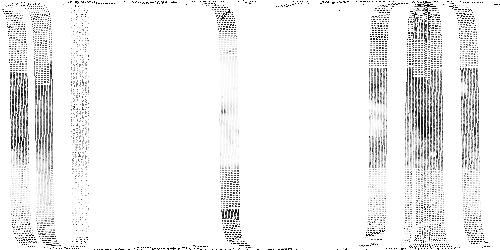

In [6]:
# display it
img

## Saving the Image

Once the image is computed, it is stored only in memory. To be used over GeoServer, we need to save it as a GeoTiff. GeoTiff is an image format that contains the raster data along with other metadata (footprints, band info, etc.)

We do a listing for all .tif images to show that the image is saved on disk

Afterwards, we can send the layer name to nayone connected to the GeoServer instance and cache results based on lifespan. 

In [7]:
conn.save_image("test.tif")

In [8]:
ls *.tif 

test.tif


## Interacting with Geoserver using gsconfig

`gsconfig` allows us to interact with Geoserver via its rest API. We now use GeoServer to generate a new layer using the hash from the query used to generate the image. This makes sure we can uniquely identify each layer. If a particular query creates the same hash, then we can return the same data layer of recomputing everything.

In [9]:
# import gsconfig stuff
import geoserver
import geoserver.util
from geoserver.catalog import Catalog

# connect to the catalog
cat = Catalog("http://localhost:8080/geoserver/rest/")

In [10]:
# get the selene workspace
workspace = cat.get_workspace("selene")

In [16]:
pstring = json.dumps(projection)
qstring = json.dumps(query)

cat.create_coveragestore(hash_string(qstring, pstring), "test.tif", workspace,overwrite=True)
print("New layer created: " + hash_string(qstring,pstring))

New layer created: 099c0d43691bcc17dc067e620e9d71c6924715cb6cd0bd5428258246


In [17]:
# Display the current layers
[layer.name for layer in cat.get_layers()]

['85eadfa1942069af70011c7f6be23cf667056cf1a977f070bc7a00bc',
 'f04eb355303e8cd2e8f5583cea1a9e14fceee970deccbff62c7bbb5b',
 'images',
 'images_alt',
 'rest',
 'usgs',
 'f1df4eca49f22d39d33341d47871c954942be5158c9af8c9dc7adef6',
 '099c0d43691bcc17dc067e620e9d71c6924715cb6cd0bd5428258246']